In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

import folium
import geopandas as gpd

from data_prep import data_prep
import get_model
import utils

seed = 42
np.random.seed(seed)

In [2]:
# Read datasets
dfbio = pd.read_csv('dataset\Biomass_History.csv')
dfdist = pd.read_csv('dataset\Distance_Matrix.csv')
submission = pd.read_csv('dataset\sample_submission.csv')
dfext = pd.read_excel('dataset\External_Data.xlsx')
dfreal = pd.read_csv('dataset\Biomass_Private.csv')

data_loader = data_prep()
data_loader.create_images(width=80, height=64)
selected_pix = data_loader.selected_pix
images = data_loader.get_images()

## Forecast - Data Prep

In [3]:
# Expand dfbio dataset
dfbio_long = pd.melt(dfbio, id_vars=['Index','Latitude','Longitude'], var_name='Year', value_name='Bio')
dfbio_long['Year'] = dfbio_long['Year'].astype(int)
dfbio_long['Bio'] = dfbio_long['Bio'].astype(float)

In [4]:
dfbio['mean_bio'] = (dfbio['2010']+dfbio['2011']+dfbio['2012']+dfbio['2013']+dfbio['2014']+dfbio['2015']+dfbio['2016']+dfbio['2017'])/8

In [5]:
# Aggregate external dataset
dfext_annual = dfext.groupby('Year').agg({
    "Avg_Temp" : "mean",
    "Min_Temp" : "min",
    "Max_Temp" : "max",
    "Rainfall" : "sum",
    "Rain_Days" : "sum",
    "Cloud" : "mean",
    "Humidity" : "mean",
    "Sun_Hours" : "sum",
    "Sun_Days" : "sum",
    "UV_Index" : "mean",
    "Pressure": "mean",
    "Avg_Gust": "mean",
    "Max_Wind": "max",
    "Avg_Wind": "mean",
}).reset_index()

In [6]:
train_coords = dfbio.drop_duplicates(subset = ['Latitude', 'Longitude'])
geometry = gpd.points_from_xy(train_coords.Longitude, train_coords.Latitude)
geo_df = gpd.GeoDataFrame(
    train_coords[["Latitude", "Longitude"]], geometry=geometry
)

# Create a canvas to plot your map on
all_data_map = folium.Map(prefer_canvas=True)

# Create a geometry list from the GeoDataFrame
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in geo_df.geometry]

# Define a colormap (you can choose any colormap from matplotlib)
colormap = plt.cm.jet

# Normalize 'Value' column to fit between 0 and 1 for colormap
norm = plt.Normalize(vmin=train_coords['mean_bio'].min(), vmax=train_coords['mean_bio'].max())\

# Iterate through list and add a marker for each location
for coordinates, value in zip(geo_df_list, train_coords['mean_bio']):
    # Get the color from the colormap
    color = plt.cm.colors.to_hex(colormap(norm(value)))
    
    # Place the markers 
    all_data_map.add_child(
        folium.CircleMarker(
            location=coordinates,
            radius = 1,
            weight = 4,
            zoom =10,
            color = color),
        )   

all_data_map.fit_bounds(all_data_map.get_bounds())
all_data_map

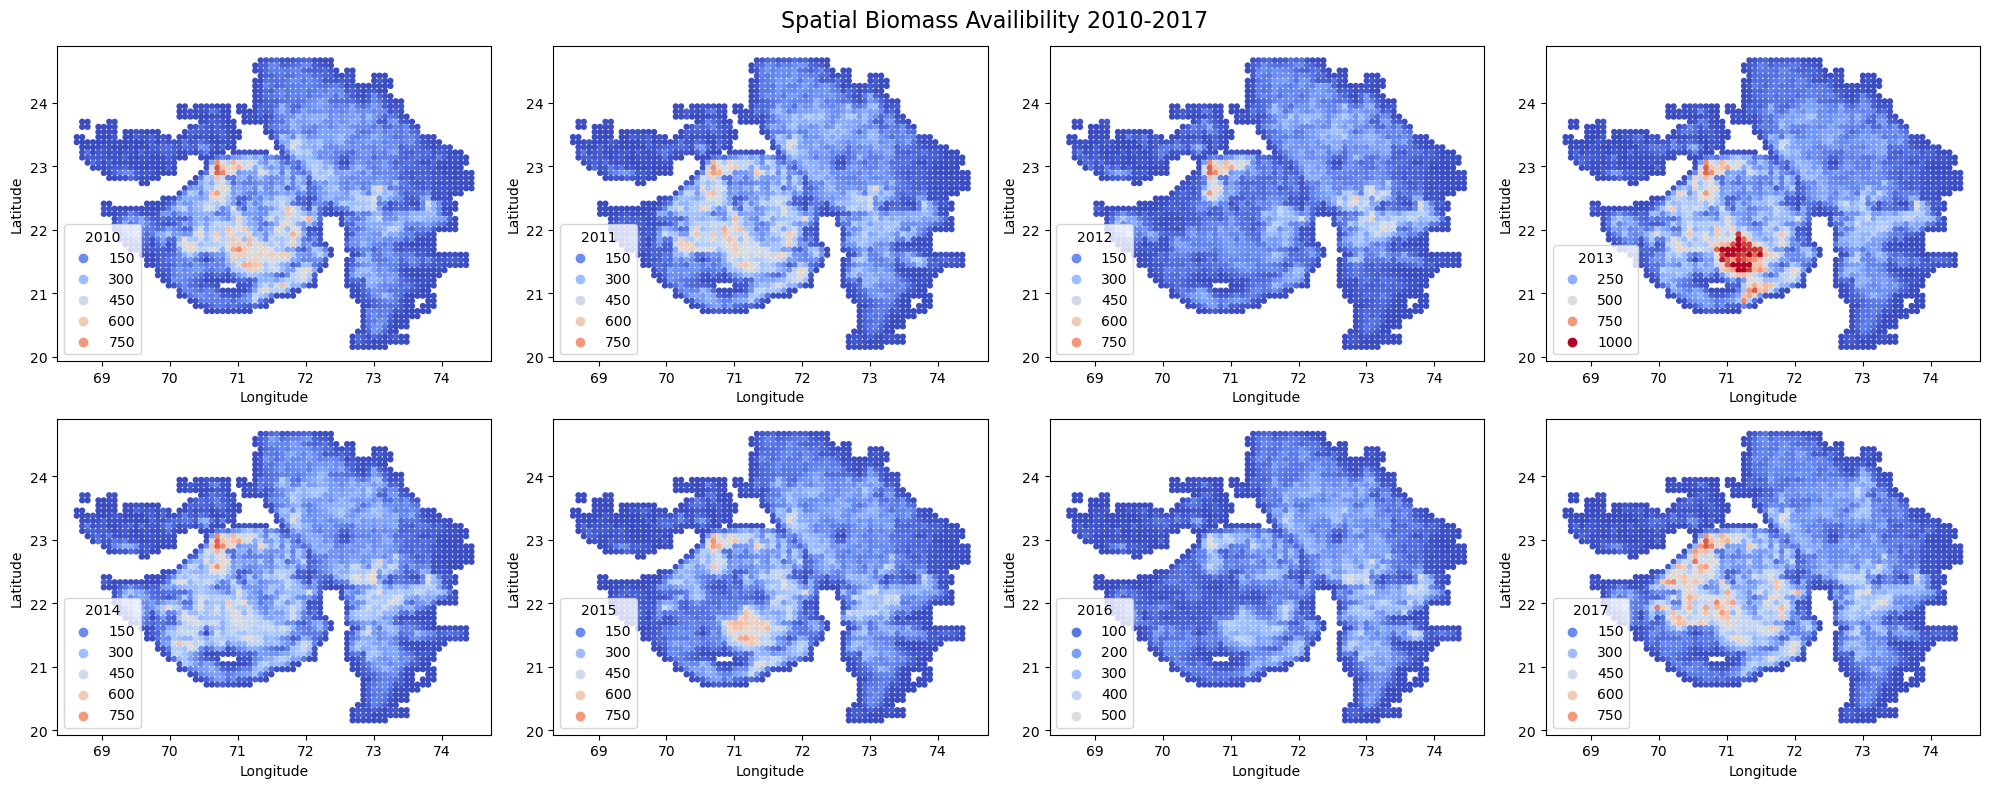

In [7]:
# Initial analysis
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))

for i, ax in enumerate(axes.flatten()) :
    sns.scatterplot(data = dfbio, x='Longitude',y='Latitude', hue=str(2010+i), ax=ax, palette='coolwarm', hue_norm=(0,1000), s=20, linewidth=0)

fig.suptitle('Spatial Biomass Availibility 2010-2017', fontsize=16)
plt.tight_layout()
plt.show()

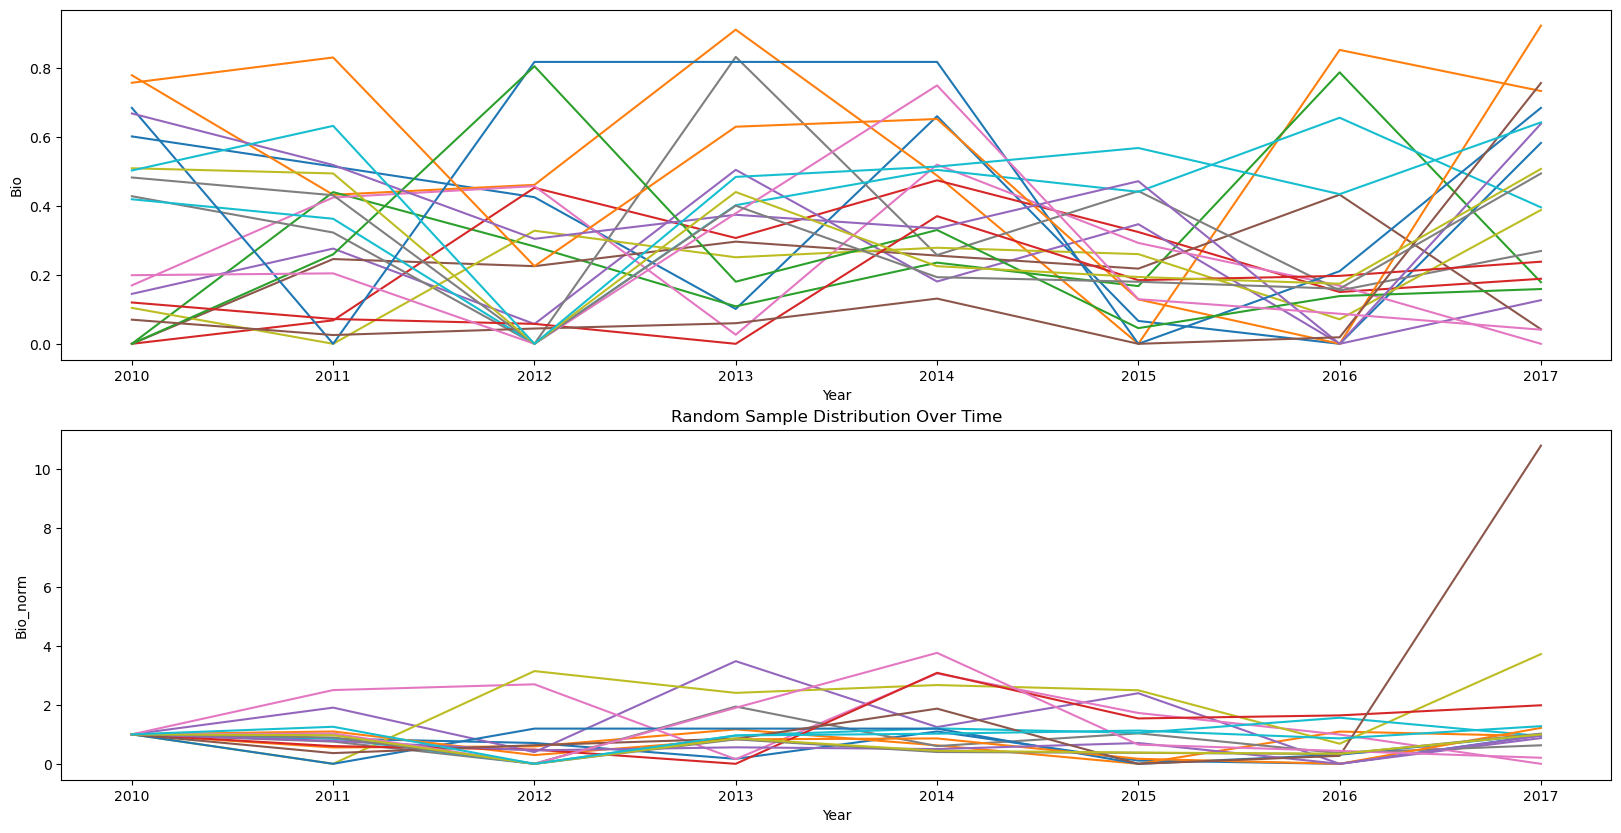

In [8]:
# Create dataframe for timeseries clustering
dfts = dfbio.drop(columns=['Latitude','Longitude','mean_bio'])
year_cols = dfts.columns[1:]

# Create a normalized dataframe and expand
dfts_norm = dfts.copy()
dfts_norm[year_cols] = dfts_norm.apply(lambda row: (row[year_cols] - row[year_cols].min())/row[year_cols].max(), axis=1)
dfts_long = pd.melt(dfts_norm, id_vars=['Index'], var_name='Year', value_name='Bio')

fig, axes = plt.subplots(nrows=2, figsize=(20, 10))

# Selecting 100 random unique indices
random_indices = np.random.choice(dfts_long['Index'].unique(), size=20, replace=False)

for i in random_indices:
    sns.lineplot(data=dfts_long[dfts_long['Index'] == i], x='Year', y='Bio', ax=axes[0])
    ts = dfts_long[dfts_long['Index'] == i].groupby('Year')['Bio'].mean()
    ts = ts/ts.loc['2010']
    sns.lineplot(ts, ax=axes[1])
    
# Adding title and changing y-axis label
plt.title('Random Sample Distribution Over Time')
plt.ylabel('Bio_norm')

plt.show()

In [9]:
from minisom import MiniSom
from collections import Counter
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.preprocessing import StandardScaler

In [15]:
class KmeansDBAClassifier:
    def __init__(self, x=4, y=6):
        self.x = x
        self.y = y
        self.clusters = self.x*self.y
    
    def train(self, dfts_norm):
        self.df = dfts_norm.copy()
        self.series_data = dfts_norm.drop(columns=['Index']).values

        self.tskm = TimeSeriesKMeans(n_clusters=self.clusters, metric="dtw", random_state=42)
        self.labels = self.tskm.fit_predict(self.series_data)

    def get_silhouette_score(self):
        silhouette_avg = silhouette_score(self.series_data, self.labels)
        return silhouette_avg
    
    def plot_cluster(self):
        fig, axes = plt.subplots(self.y, self.x,figsize=(self.x*5,self.y*5))
        for y in range(self.y):
            for x in range(self.x):
                cluster = (x,y)
                cluster_series = self.series_data[self.labels==(x+x*y)]
                for series in cluster_series:
                    axes[cluster].plot(series,c="gray",alpha=0.5)
                axes[cluster].plot(dtw_barycenter_averaging(np.vstack(cluster_series)),c="red")
            
        plt.tight_layout()
        plt.show()

    def get_df_label(self):
        dflabel = pd.concat([self.df['Index'],pd.Series(self.labels, name='Label')], axis=1)
        return dflabel
    
    def plot_distribution(self):
        df = self.get_df_label()
        df['Label'].value_counts().plot(kind='bar', figsize=(15,4), title='Distribution')

In [16]:
class KmeansClassifier:
    def __init__(self, x=4, y=6):
        self.x = x
        self.y = y
        self.clusters = self.x*self.y
    
    def train(self, dfts_norm):
        self.df = dfts_norm.copy()
        self.series_data = dfts_norm.drop(columns=['Index']).values

        self.km = KMeans(n_clusters=self.x*self.y, n_init=10, random_state=42)
        self.labels = self.km.fit_predict(self.series_data)

    def get_silhouette_score(self):
        silhouette_avg = silhouette_score(self.series_data, self.labels)
        return silhouette_avg
    
    def plot_cluster(self):
        fig, axes = plt.subplots(self.y, self.x,figsize=(self.x*5,self.y*5))
        for y in range(self.y):
            for x in range(self.x):
                cluster = (y,x)
                cluster_series = self.series_data[self.labels==(x+x*y)]
                for series in cluster_series:
                    axes[cluster].plot(series,c="gray",alpha=0.5)
                axes[cluster].plot(dtw_barycenter_averaging(np.vstack(cluster_series)),c="red")
            
        plt.tight_layout()
        plt.show()

    def get_df_label(self):
        dflabel = pd.concat([self.df['Index'],pd.Series(self.labels, name='Label')], axis=1)
        return dflabel
    
    def plot_distribution(self):
        df = self.get_df_label()
        df['Label'].value_counts().plot(kind='bar', figsize=(15,4), title='Distribution')

In [17]:
class SOMClassifier:
    def __init__(self, som_x=5, som_y=5, learning_rate=0.05):
        self.som_x = som_x
        self.som_y = som_y
        self.learning_rate = learning_rate

    def train(self, dfts_norm):
        series_data = dfts_norm.drop(columns=['Index']).values

        self.som = MiniSom(self.som_x, self.som_y, input_len=series_data.shape[1], learning_rate=self.learning_rate, random_seed=42)
        self.som.random_weights_init(series_data)

        num_epochs = 50000
        self.som.train_random(series_data, num_epochs)

        self.winners = self.som.win_map(series_data)

        cluster_indices = list(self.winners.keys())
        self.winners_indexed = {f"Cluster {i+1}": self.winners[cluster_indices[i]] for i in range(len(cluster_indices))}

        self.list_of_series = np.array([series for series_list in self.winners_indexed.values() for series in series_list])

        self.cluster_labels = []
        for cluster, series_list in self.winners_indexed.items():
            self.cluster_labels.extend([cluster] * len(series_list))

        self.cluster_labels = np.array(self.cluster_labels)

    def get_silhouette_score(self):
        silhouette_avg = silhouette_score(self.list_of_series, self.cluster_labels)
        return silhouette_avg
    
    def plot_cluster(self):
        fig, axs = plt.subplots(self.som_x,self.som_y,figsize=(min(self.som_x,self.som_y)*5,max(self.som_x,self.som_y)*5))
        for x in range(self.som_x):
            for y in range(self.som_y):
                cluster = (x,y)
                if cluster in self.winners.keys():
                    for series in self.winners[cluster]:
                        axs[cluster].plot(series,c="gray",alpha=0.5) 
                    axs[cluster].plot(dtw_barycenter_averaging(np.vstack(self.winners[cluster])),c="red")
                cluster_number = x*self.som_y+y+1
                axs[cluster].set_title(f"Cluster {cluster_number}")
            
        plt.tight_layout()
        plt.show()

    def get_df_label(self):
        columns = ['2010','2011','2012','2013','2014','2015','2016','2017','Label']
        dflabel = pd.DataFrame(columns=columns)

        rows = []
        for cluster, series_list in self.winners_indexed.items():
            for series in series_list:
                new_row = {'2010': series[0], '2011': series[1], '2012': series[2],
                        '2013': series[3], '2014': series[4], '2015': series[5],
                        '2016': series[6], '2017': series[7], 'Label': cluster}
                rows.append(new_row)

        dflabel = pd.concat([dflabel, pd.DataFrame(rows)], ignore_index=True)
        dflabel = dfts_norm.merge(dflabel, on=list(year_cols), how='left').drop(columns=list(year_cols))
        return dflabel
    
    def plot_distribution(self):
        df = self.get_df_label()
        df['Label'].value_counts().plot(kind='bar', figsize=(15,4), title='Distribution')
    
    

In [18]:
som_x = 5
som_y = 5
som_classifier = SOMClassifier(som_x=som_x, som_y=som_y)

som_classifier.train(dfts_norm)

som_silhouette_score = som_classifier.get_silhouette_score()
print(f'Silhouette Score: {som_silhouette_score}')

TSKMClassifier = KmeansDBAClassifier(x=som_y,y=som_x)
TSKMClassifier.train(dfts_norm)

tskm_silhouette_score = TSKMClassifier.get_silhouette_score()
print(f'Silhouette Score: {tskm_silhouette_score}')

km_classifier = KmeansClassifier(x=som_y,y=som_x)
km_classifier.train(dfts_norm)

km_silhouette_score = km_classifier.get_silhouette_score()
print(f'Silhouette Score: {km_silhouette_score}')

Silhouette Score: 0.25572244975531305
Silhouette Score: 0.1256597828143035


c:\Users\Acer\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


Silhouette Score: 0.27341369055561654


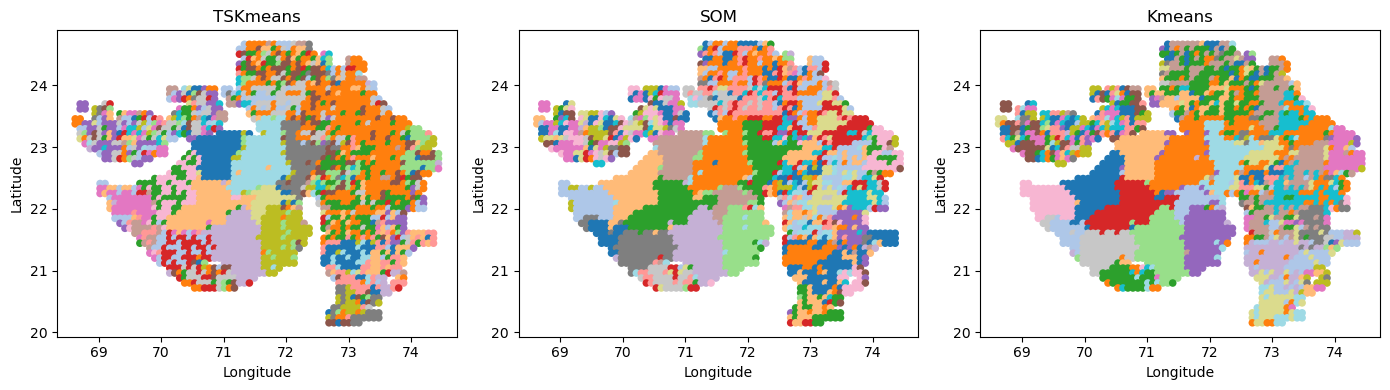

In [19]:
dfmean = dfbio_long.groupby(['Index','Latitude','Longitude'])['Bio'].mean().reset_index()
dflabel_tskm = TSKMClassifier.get_df_label()
dflabel_som = som_classifier.get_df_label()
dflabel_km = km_classifier.get_df_label()

fig, axes = plt.subplots(ncols=3, figsize=(14,4))

n_colors = som_x*som_y
palette = sns.color_palette("tab20", n_colors=n_colors)
plot = sns.scatterplot(data=pd.merge(dfmean,dflabel_tskm,on='Index'),x='Longitude',y='Latitude',hue='Label', palette=palette, s=30, linewidth=0, legend=False, ax=axes[0])
axes[0].set_title('TSKmeans')
plot = sns.scatterplot(data=pd.merge(dfmean,dflabel_som,on='Index'),x='Longitude',y='Latitude',hue='Label', palette=palette, s=30, linewidth=0, legend=False, ax=axes[1])
axes[1].set_title('SOM')
plot = sns.scatterplot(data=pd.merge(dfmean,dflabel_km,on='Index'),x='Longitude',y='Latitude',hue='Label', palette=palette, s=30, linewidth=0, legend=False, ax=axes[2])
axes[2].set_title('Kmeans')

plt.tight_layout()
plt.show()

## Forecast - Model

In [10]:
df_train = dfbio_long
df_2018 = dfbio_long.loc[dfbio_long['Year'] == 2010].drop(columns='Bio')
df_2018['Year'] = 2018
df_2019 = dfbio_long.loc[dfbio_long['Year'] == 2010].drop(columns='Bio')
df_2019['Year'] = 2019

In [11]:
def add_label(df, df2018, df2019, label, OHE=False): #dflabel
    df = pd.merge(df, label[['Index','Label']], on=['Index'], how='left')
    df2018 = pd.merge(df2018, label[['Index','Label']], on=['Index'], how='left')
    df2019 = pd.merge(df2019, label[['Index','Label']], on=['Index'], how='left')
    if OHE :
        return pd.get_dummies(df, columns=['Label']),pd.get_dummies(df2018, columns=['Label']),pd.get_dummies(df2019, columns=['Label'])
    else :
        return df, df2018, df2019
    
def add_ext(df, df2018, df2019, dfext): #annual_dfext
    return pd.merge(df, dfext, on='Year', how='left'), pd.merge(df2018, dfext, on='Year', how='left'), pd.merge(df2019, dfext, on='Year', how='left')

In [21]:
df_train_regres, df_2018_regres, df_2019_regres = add_ext(df_train, df_2018, df_2019, dfext_annual)

In [22]:
df_train_whole, df_2018_whole, df_2019_whole = add_label(df_train, df_2018, df_2019,dflabel_km, OHE=True)
df_train_whole, df_2018_whole, df_2019_whole = add_ext(df_train_whole, df_2018_whole, df_2019_whole, dfext_annual)

In [23]:
# Import machine learning frameworks
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
import optuna

In [24]:
def create_pipeline(model, scaler):
    pipeline = Pipeline([
        ('scaler', scaler),  # Standardize the features
        ('model', model)  # Your chosen model
    ])
    return pipeline

def eval_whole(model, splits, dftrain):
    train_err = []
    valid_err = []

    X = dftrain.copy().drop(columns=['Index'])
    y = X.pop('Bio')

    tscv = TimeSeriesSplit(n_splits=splits, test_size=2418)

    for train_index, valid_index in tscv.split(X):
        valid_year = X.iloc[valid_index]['Year'].unique()[0]
        # print(f"Testing on year : {valid_year}")

        x_train, y_train = X.iloc[train_index], y.iloc[train_index]
        x_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]

        pipeline = create_pipeline(model, MinMaxScaler())

        pipeline.fit(x_train, y_train)

        train_pred = pipeline.predict(x_train)
        valid_pred = pipeline.predict(x_valid)

        train_score = mean_absolute_error(y_train, train_pred)
        valid_score = mean_absolute_error(y_valid, valid_pred)

        train_err.append(train_score)
        valid_err.append(valid_score)

        # print(f'Train Score {train_score:.5f}, Valid Score {valid_score:.5f}')

    print(f'Mean Train Score : {np.mean(train_err):.5f}, Mean Valid Score : {np.mean(valid_err):.5f}')

    return train_err, valid_err, pipeline

def eval_linear(model, dftrain):
    mae_list = []
    for i in dftrain['Index'].unique():
        X = dftrain[dftrain['Index']==i].drop(['Index','Latitude','Longitude'],axis=1)
        y = X.pop('Bio')

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
        pipeline = create_pipeline(model, MinMaxScaler())
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mae_list.append(mae)

    print(f"Mean Absolute Error (MAE): {np.mean(mae_list)}")
    return mae_list

In [25]:
error_dict = {}

In [26]:
models = {
    'RF' : RandomForestRegressor(random_state=seed, verbose=0),
}

In [27]:
for model in models.keys():
    print(f'Model {model} : ')
    t_err, v_err, train_model = eval_whole(models[model], 4, df_train_whole)
    error_dict[model] = np.mean(v_err)

Model RF : 
Mean Train Score : 8.87189, Mean Valid Score : 45.25128


In [28]:
import tensorflow as tf

In [29]:
X = df_train_whole.copy()
y = X.pop('Bio')
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

In [30]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  
])

In [31]:
def lr_schedule(epoch):
    if epoch < 250:
        return 0.05
    elif epoch < 450:
        return 0.01
    elif epoch < 550:
        return 0.005
    elif epoch < 600:
        return 0.001
    else :
        return 0.0005
    
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, verbose=1, restore_best_weights=True)

In [32]:
model.compile(optimizer='adam', loss='mean_absolute_error')

In [33]:
_ = model.fit(X_train, y_train, epochs=1000, batch_size=256, callbacks=[early_stopping, lr_scheduler], validation_data=(X_test, y_test))

Epoch 1/1000
57/57 [==============================] - 1s 5ms/step - loss: 95.4090 - val_loss: 88.6867 - lr: 0.0500
Epoch 2/1000
57/57 [==============================] - 0s 3ms/step - loss: 90.3305 - val_loss: 86.8127 - lr: 0.0500
Epoch 3/1000
57/57 [==============================] - 0s 2ms/step - loss: 87.6471 - val_loss: 85.5914 - lr: 0.0500
Epoch 4/1000
57/57 [==============================] - 0s 2ms/step - loss: 85.6328 - val_loss: 88.4375 - lr: 0.0500
Epoch 5/1000
57/57 [==============================] - 0s 2ms/step - loss: 85.0597 - val_loss: 82.7532 - lr: 0.0500
Epoch 6/1000
57/57 [==============================] - 0s 2ms/step - loss: 82.2147 - val_loss: 82.5053 - lr: 0.0500
Epoch 7/1000
57/57 [==============================] - 0s 2ms/step - loss: 80.7086 - val_loss: 81.6050 - lr: 0.0500
Epoch 8/1000
57/57 [==============================] - 0s 2ms/step - loss: 79.8281 - val_loss: 79.3628 - lr: 0.0500
Epoch 9/1000
57/57 [==============================] - 0s 2ms/step - loss: 79.265

In [34]:
loss = model.evaluate(X_scaled, y)
print(f'Mean Absolute Error: {loss:.4f}')

605/605 [==============================] - 1s 929us/step - loss: 39.4874
Mean Absolute Error: 39.4874


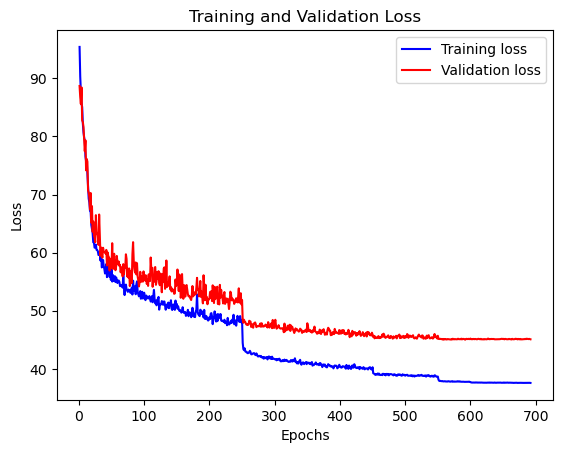

In [35]:
# Access the training and validation loss from the history
train_loss = _.history['loss']
val_loss = _.history['val_loss']

# Create a range of epochs for x-axis
epochs = range(1, len(train_loss) + 1)

# Plotting
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show plot
plt.show()

In [36]:
models_linear = {
    'LinReg' : LinearRegression(),
    'Enet' : ElasticNet(random_state=seed)
}

In [37]:
for model in models_linear.keys() :
    print(f'Model {model} : ')
    err = eval_linear(models_linear[model], df_train_regres)
    error_dict[model] = np.mean(err)


Model LinReg : 
Mean Absolute Error (MAE): 45.6328268284349
Model Enet : 
Mean Absolute Error (MAE): 31.965061464429574


In [90]:
image_data = data_loader.dfbio

In [97]:
unet = get_model.Unet(image_data, images)

_, _, X_val_unet, y_val_unet = unet.prepare_data(fit=False)
model_unet = unet.get_model()
model_unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mae')

model_unet.load_weights('saved_models\\Unet_M_300_30.757_val.h5')

error_dict['Unet'] = model_unet.evaluate(X_val_unet, y_val_unet)

1/1 [==============================] - 0s 344ms/step - loss: 29.1419


In [103]:
lstm_3 = get_model.LSTM_3(image_data)

_, _, X_val_lstm, y_val_lstm = lstm_3.prepare_data(fit=False)
model_lstm = lstm_3.get_model()
model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae')

model_lstm.load_weights('saved_models\\LSTM_3_300_35.187_val.h5')

error_dict['LSTM'] = model_lstm.evaluate(X_val_lstm, y_val_lstm)

1/1 [==============================] - 0s 358ms/step - loss: 35.0586


In [104]:
clstm_3 = get_model.ConvLSTM_3(image_data, images)

_, _, X_val_clstm, y_val_clstm = clstm_3.prepare_data(fit=False)
model_clstm = clstm_3.get_model()
model_clstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mae')

model_clstm.load_weights('saved_models\\ConvLSTM_M_300_26.04_val.h5')

error_dict['ConvLSTM'] = model_clstm.evaluate(X_val_clstm, y_val_clstm)

1/1 [==============================] - 1s 808ms/step - loss: 25.3714


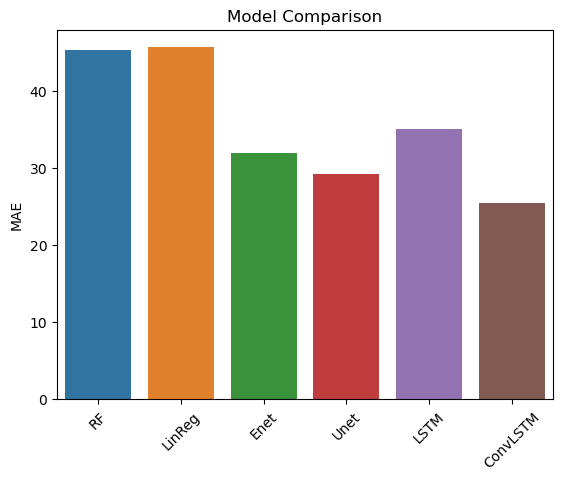

In [105]:
sns.barplot(x=list(error_dict.keys()), y=list(error_dict.values()))

# Add title and label
plt.title('Model Comparison')
plt.ylabel('MAE')

# Rotate x-axis labels for better visibility (optional)
plt.xticks(rotation=45)

# Show the plot
plt.show()

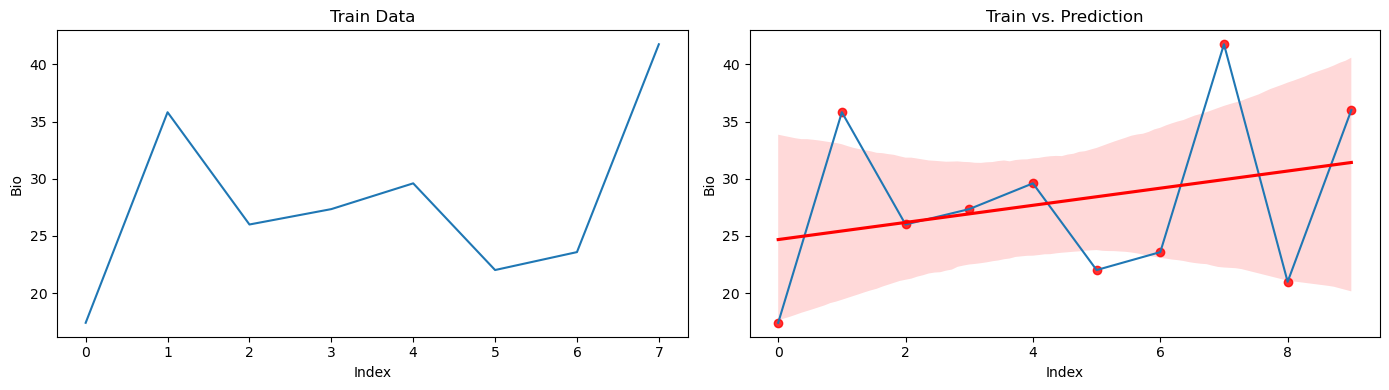

In [106]:
fig, axes = plt.subplots(ncols=2, figsize=(14,4))

model = ElasticNet()
pipeline = create_pipeline(model, StandardScaler())

i = 5

X = df_train_regres[df_train_regres['Index']==i].drop(['Index','Latitude','Longitude'],axis=1)
y = X.pop('Bio')

X_2018 = df_2018_regres[df_2018_regres['Index']==i].drop(['Index','Latitude','Longitude'],axis=1)
X_2019 = df_2019_regres[df_2019_regres['Index']==i].drop(['Index','Latitude','Longitude'],axis=1)

_ = pipeline.fit(X,y)
pred_2018 = pipeline.predict(X_2018)
pred_2019 = pipeline.predict(X_2019)

df_train_regres[df_train_regres['Index']==i]['Bio'].reset_index(drop=True).plot(ax=axes[0])
axes[0].set_ylabel('Bio')
axes[0].set_xlabel('Index')
axes[0].set_title('Train Data')

bio_list = df_train_regres[df_train_regres['Index']==i]['Bio'].tolist()
bio_list.append(int(pred_2018))
bio_list.append(int(pred_2019))
pd.Series(bio_list).plot(ax=axes[1])
axes[1].set_ylabel('Bio')
axes[1].set_xlabel('Index')
axes[1].set_title('Train vs. Prediction')

# Add regression line on the second plot
sns.regplot(x=list(range(len(bio_list))), y=bio_list, ax=axes[1], color='red')

# Show the plots
plt.tight_layout()
plt.show()

In [107]:
def pred_linear(df_train, df_2018, df_2019, model):
    pred_dict = {'2018': [], '2019': []}  # Initialize a dictionary to store predictions

    # Loop through unique 'Index' values in df_train
    for i in df_train['Index'].unique():
        # Extract features and target for training
        X = df_train[df_train['Index'] == i].drop(['Index','Latitude','Longitude'],axis=1)
        y = X.pop('Bio')

        # Extract features for testing in 2018 and 2019
        X_2018 = df_2018[df_2018['Index'] == i].drop(['Index','Latitude','Longitude'],axis=1)
        X_2019 = df_2019[df_2019['Index'] == i].drop(['Index','Latitude','Longitude'],axis=1)

        # Create and fit the pipeline
        pipeline = create_pipeline(model, MinMaxScaler())
        _ = pipeline.fit(X, y)

        # Make predictions for 2018 and 2019
        pred_2018 = pipeline.predict(X_2018)
        pred_2019 = pipeline.predict(X_2019)

        # Append predictions to the dictionary
        pred_dict['2018'].append(int(pred_2018))
        pred_dict['2019'].append(int(pred_2019))

    return pred_dict


In [ ]:
model = ElasticNet()
predictions = pred_linear(df_train_regres, df_2018_regres, df_2019_regres, model)

In [109]:
model_clstm.load_weights('saved_models\\ConvLSTM_M_300_26.04.h5')

In [113]:
clstm_3.model = model_clstm

In [117]:
preds_image, predictions = clstm_3.predict(selected_pix)

1/1 [==============================] - 0s 204ms/step


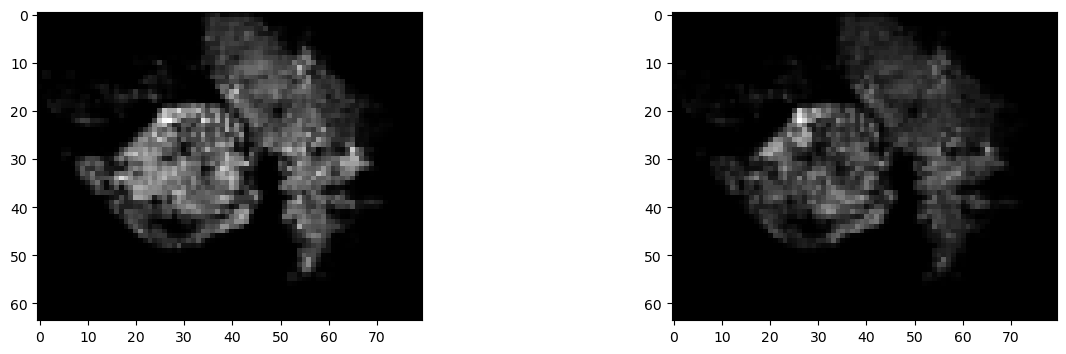

In [118]:
fig, axes = plt.subplots(1,2,figsize=(15,4))
axes[0].imshow(preds_image[0][0,:,:,0], cmap='gray')
axes[1].imshow(preds_image[1][0,:,:,0], cmap='gray')

In [131]:
df_2018['2018'] = [int(x) for x in predictions['2018']]
df_2019['2019'] = [int(x) for x in predictions['2019']]

In [132]:
print(df_2018['2018'].sum(), df_2018['2018'].sum()*0.8, df_2018['2018'].mean())
print(df_2019['2019'].sum(), df_2019['2019'].sum()*0.8, df_2019['2019'].mean())

321031 256824.80000000002 132.7671629445823
326667 261333.6 135.09801488833747


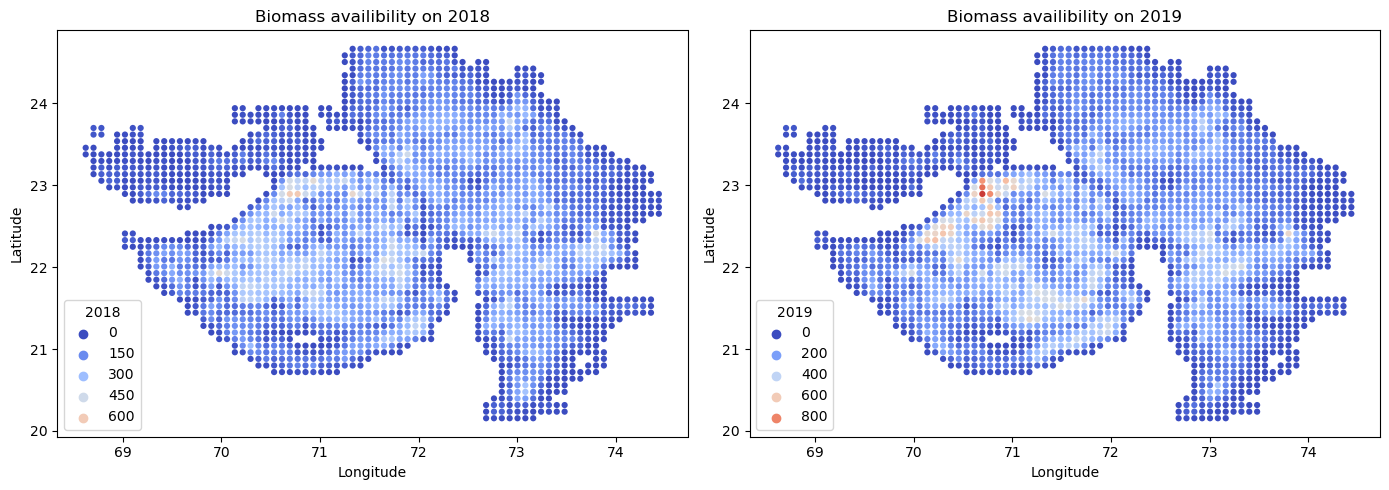

In [133]:
# Prediction results on year 2018 and year 2019
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
sns.scatterplot(data=df_2018,x='Longitude',y='Latitude',hue='2018', palette='coolwarm', hue_norm=(0,1000), s=20, linewidth=0, ax=axes[0])
axes[0].set_title('Biomass availibility on 2018')
sns.scatterplot(data=df_2019,x='Longitude',y='Latitude',hue='2019', palette='coolwarm', hue_norm=(0,1000), s=20, linewidth=0, ax=axes[1])
axes[1].set_title('Biomass availibility on 2019')

plt.tight_layout()
plt.show()

In [134]:
def real_eval(dfreal, predictions):
    mae_2018 = mean_absolute_error(dfreal['2018'], predictions['2018'])
    mae_2019 = mean_absolute_error(dfreal['2019'], predictions['2019'])
    return mae_2018,mae_2019

In [135]:
real_eval(dfreal, predictions)

(33.83602106166651, 49.93557167704602)

In [136]:
dfpred_2018 = df_2018[['Index','Latitude','Longitude','2018']]
dfpred_2019 = df_2019[['Index','Latitude','Longitude','2019']]
dfcluster = dfpred_2018.merge(dfpred_2019, on =['Index','Latitude','Longitude'])

dfcluster.head(5)

Index  Latitude  Longitude  2018  2019
0      0  24.66818   71.33144     7     6
1      1  24.66818   71.41106    42    32
2      2  24.66818   71.49069    60    67
3      3  24.66818   71.57031    86    75
4      4  24.66818   71.64994    18    22

In [137]:
from pulp import *
from ortools.linear_solver import pywraplp

In [144]:
used_2018 = []
group_dict_2018 = {}
costs_2018 = []

used_2019 = [] 
group_dict_2019 = {}
costs_2019 = []

In [ ]:
class MILP_Single():
    def __init__(self, dfcluster, year, iter, cap=2000):
        self.used = []
        self.group_dict = {}
        self.costs = []
        self.iter=iter
        self.cap = 20000
        self.year = year

        self.avail = dfcluster[~dfcluster['Index'].isin(self.used)]
        self.sites = self.avail['Index'].tolist()
        self.depots = self.avail[str(year)].nlargest(iter).index.tolist()
    
    def update(self, used):
        self.avail = dfcluster[~dfcluster['Index'].isin(used)]
        self.sites = self.avail['Index'].tolist()
        self.depots = self.avail[str(self.year)].nlargest(self.iter).index.tolist()

    def init_solver(self):
        solver = pywraplp.Solver.CreateSolver('SCIP')
        if not self.solver:
            raise Exception("Solver initialization failed")
        
        return solver
    
    def init_optvar(self):
        self.use_depot = {}
        self.assign_depot = {}

        for j in self.depots:
            self.use_depot[j] = self.solver.BoolVar(f"Use Depot {j}")

        for i in self.sites:
            for j in self.depots:
                self.assign_depot[(i, j)] = self.solver.BoolVar(f"Assign Depot {i},{j}")

    def run(self):
        solver = self.init_solver()

In [145]:
for iter_index in tqdm(range(15), desc='Optimize'):
    avail = dfcluster[~dfcluster['Index'].isin(used_2018)]
    max_iter = 5
    maxval_index = avail['2018'].nlargest(max_iter).index.tolist()
    Sites = avail['Index'].tolist()
    Depots = maxval_index
    Biomass = avail.copy()['2018']
    cap = 20000

    solver = pywraplp.Solver.CreateSolver('SCIP')
    if not solver:
        raise Exception("Solver initialization failed")

    use_depot = {}
    assign_depot = {}

    for j in Depots:
        use_depot[j] = solver.BoolVar(f"Use Depot {j}")

    for i in Sites:
        for j in Depots:
            assign_depot[(i, j)] = solver.BoolVar(f"Assign Depot {i},{j}")

    trans_cost = solver.Sum(
        dfdist[str(j)][int(i)] * Biomass[i] * assign_depot[i, j]
        for i in Sites for j in Depots
    )

    under_cost = solver.Sum(
        cap * use_depot[j] - solver.Sum(
            Biomass[i] * assign_depot[i, j] for i in Sites
        ) for j in Depots
    )

    # Combine transportation cost and fixed cost for the total cost
    total_cost = trans_cost*0.001 + under_cost
    solver.Minimize(total_cost)

    solver.Add(solver.Sum(use_depot[j] for j in Depots) == 1)

    for i in Sites:
        for j in Depots:
            solver.Add(assign_depot[i, j] <= use_depot[j])

    for j in Depots:
        solver.Add(solver.Sum(Biomass[i] * assign_depot[i, j] for i in Sites) - cap * use_depot[j] <= 0)
        solver.Add(solver.Sum(Biomass[i] * assign_depot[i, j] for i in Sites) - 0.9 * cap * use_depot[j] >= 0)

    for i in Sites:
        solver.Add(solver.Sum(assign_depot[i, j] for j in Depots) <= 1)

    status = solver.Solve()

    losses = (total_cost.solution_value(), trans_cost.solution_value(), under_cost.solution_value())
    costs_2018.append(losses)

    variable_values = {
        var.name(): var.solution_value() for var in [use_depot[j] for j in Depots] +
        [assign_depot[i, j] for i in Sites for j in Depots]
    }

    group_assign_dict = {}
    centers = []
    for var_name, var_value in variable_values.items():
        if var_value > 0 :
            line = var_name
            if line.startswith('Assign Depot'):
                key = int(line.split(',')[1])
                value = int(line.split(',')[0].split(' ')[2])
                if key in group_assign_dict:
                    group_assign_dict[key].append(value)
                else:
                    group_assign_dict[key] = [value]
            else :
                centers.append(int(line.split(' ')[2]))

    for value_list in group_assign_dict.values():
        used_2018.extend(value_list)

    group_dict_2018.update(group_assign_dict)
    print(centers, losses)

Optimize:   7%|▋         | 1/15 [00:29<06:46, 29.00s/it]

[921] (813.2288902000037, 813228.8901999998, 0.0)


Optimize:  13%|█▎        | 2/15 [01:06<07:24, 34.19s/it]

[1530] (759.0436872000028, 759043.6872, 0.0)


Optimize:  20%|██        | 3/15 [01:46<07:22, 36.90s/it]

[1322] (855.8733964999956, 855873.3964999999, 0.0)


Optimize:  27%|██▋       | 4/15 [02:21<06:35, 35.94s/it]

[1288] (832.408968300002, 832408.9683000002, 0.0)


Optimize:  33%|███▎      | 5/15 [02:53<05:45, 34.51s/it]

[547] (881.3635129000031, 881363.5129000001, 0.0)


Optimize:  40%|████      | 6/15 [03:19<04:45, 31.72s/it]

[309] (1017.6314140000068, 1017631.4139999999, 0.0)


Optimize:  47%|████▋     | 7/15 [03:47<04:04, 30.54s/it]

[1638] (776.8885187999986, 776888.5188000001, 0.0)


Optimize:  53%|█████▎    | 8/15 [04:11<03:19, 28.51s/it]

[1607] (1031.0438408000045, 1031043.8408, 0.0)


Optimize:  60%|██████    | 9/15 [04:34<02:40, 26.80s/it]

[930] (1041.9349501999895, 1041934.9502, 0.0)


Optimize:  67%|██████▋   | 10/15 [04:55<02:03, 24.78s/it]

[1866] (1046.020926600002, 1046020.9266, 0.0)


Optimize:  73%|███████▎  | 11/15 [05:14<01:32, 23.09s/it]

[1742] (1352.5389003999953, 1352538.9004, 0.0)


Optimize:  80%|████████  | 12/15 [05:30<01:02, 20.99s/it]

[2185] (1129.8265063999934, 1129826.5064, 0.0)


Optimize:  87%|████████▋ | 13/15 [05:43<00:37, 18.54s/it]

[1433] (1582.5963413999925, 1582596.3414, 0.0)


Optimize:  93%|█████████▎| 14/15 [05:53<00:15, 15.78s/it]

[1973] (2975.972688400001, 2975972.688400002, 0.0)


Optimize: 100%|██████████| 15/15 [06:00<00:00, 24.04s/it]

[301] (1676.1751097000015, 1676175.1097000001, 0.0)


In [176]:
for iter_index in tqdm(range(3), desc='opt_2019') :
    print(f'Iter no: {iter_index+1}')
    Depots = list(group_dict_2018.keys())[5*iter_index:5*(iter_index+1)]
    Sites = dfcluster[~dfcluster['Index'].isin(used_2019 + list(group_dict_2018.keys())[5*(iter_index+1):])]['Index'].tolist()
    Biomass = dfcluster.copy()['2019']
    cap = 20000

    solver = pywraplp.Solver.CreateSolver('SCIP')
    if not solver:
        raise Exception("Solver initialization failed")

    assign_depot = {}

    for i in Sites:
        for j in Depots:
            assign_depot[(i, j)] = solver.BoolVar(f"Assign Depot {i},{j}")

    trans_cost = solver.Sum(
        dfdist[str(j)][int(i)] * Biomass[i] * assign_depot[i, j]
        for i in Sites for j in Depots
    )

    under_cost = solver.Sum(
        cap - solver.Sum(
            Biomass[i] * assign_depot[i, j] for i in Sites
        ) for j in Depots
    )

    # Combine transportation cost and fixed cost for the total cost
    total_cost = trans_cost*0.001 + under_cost
    solver.Minimize(total_cost)

    for j in Depots:
        solver.Add(solver.Sum(Biomass[i] * assign_depot[i, j] for i in Sites) - cap <= 0)
        solver.Add(assign_depot[j, j] == 1)

    for i in Sites:
        solver.Add(solver.Sum(assign_depot[i, j] for j in Depots) <= 1)

    status = solver.Solve()
    print(total_cost.solution_value())

    losses = (total_cost.solution_value(), trans_cost.solution_value(), under_cost.solution_value())
    costs_2019.append(losses)

    variable_values = {
        var.name(): var.solution_value() for var in 
        [assign_depot[i, j] for i in Sites for j in Depots]
    }

    group_assign_dict = {}
    centers = []
    for var_name, var_value in variable_values.items():
        if var_value > 0 :
            line = var_name
            if line.startswith('Assign Depot'):
                key = int(line.split(',')[1])
                value = int(line.split(',')[0].split(' ')[2])
                if key in group_assign_dict:
                    group_assign_dict[key].append(value)
                else:
                    group_assign_dict[key] = [value]
            else :
                centers.append(int(line.split(' ')[2]))

    for value_list in group_assign_dict.values():
        used_2019.extend(value_list)

    group_dict_2019.update(group_assign_dict)

opt_2019:   0%|          | 0/3 [00:00<?, ?it/s]

Iter no: 1


opt_2019:  33%|███▎      | 1/3 [00:04<00:09,  4.53s/it]

3984.0253828000423
Iter no: 2


opt_2019:  67%|██████▋   | 2/3 [00:09<00:04,  4.57s/it]

4662.152952399934
Iter no: 3


opt_2019: 100%|██████████| 3/3 [00:13<00:00,  4.35s/it]

7510.26906890003


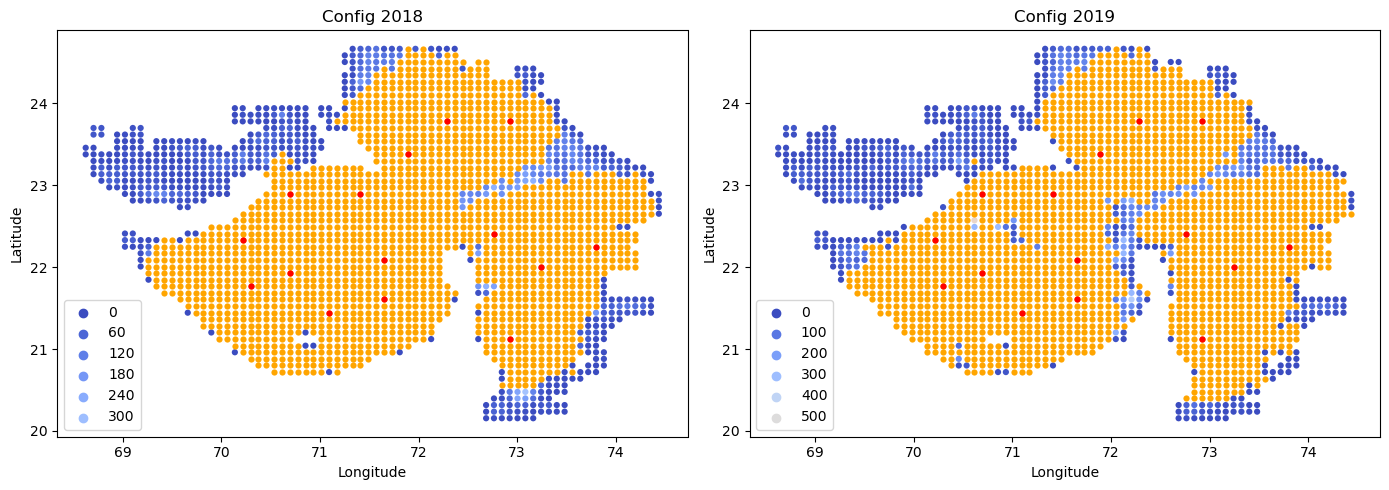

In [177]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
sns.scatterplot(data=dfcluster[~dfcluster['Index'].isin(used_2018)],x='Longitude',y='Latitude',hue='2018', palette='coolwarm', hue_norm=(0,1000), s=20, linewidth=0, ax=axes[0])
sns.scatterplot(data=dfcluster[~dfcluster['Index'].isin(used_2019)],x='Longitude',y='Latitude',hue='2019', palette='coolwarm', hue_norm=(0,1000), s=20, linewidth=0, ax=axes[1])
sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(used_2018)], x='Longitude', y='Latitude', color='orange', s=20, linewidth=0, ax=axes[0])
sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(used_2019)], x='Longitude', y='Latitude', color='orange', s=20, linewidth=0, ax=axes[1])
sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(list(group_dict_2018.keys()))], x='Longitude', y='Latitude', color='red', s=20, linewidth=0, ax=axes[0])
sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(list(group_dict_2019.keys()))], x='Longitude', y='Latitude', color='red', s=20, linewidth=0, ax=axes[1])
axes[0].set_title('Config 2018')
axes[1].set_title('Config 2019')
plt.tight_layout()
plt.show()

In [178]:
total_cost = 0
transport_cost = 0
underutil_cost = 0
for costs_ in [costs_2018, costs_2019] :
    for cost in costs_:
        total_cost += cost[0]
        transport_cost += cost[1]
        underutil_cost += cost[2]

print(f'Total cost : {total_cost}')
print(f'Total transport : {transport_cost*0.001}')
print(f'Total underutil : {underutil_cost}')

Total cost : 33928.9950559
Total transport : 33928.99505589999
Total underutil : 0.0


In [181]:
biomass_dict_2018 = {}
for keys in group_dict_2018.keys() :
    biomass_collected = 0
    for site in group_dict_2018[keys]:
        biomass_collected += dfcluster.loc[dfcluster['Index']==site]['2018'].values[0]
    biomass_dict_2018[keys] = biomass_collected
    
biomass_dict_2019 = {}
for keys in group_dict_2019.keys() :
    biomass_collected = 0
    for site in group_dict_2019[keys]:
        biomass_collected += dfcluster.loc[dfcluster['Index']==site]['2019'].values[0]
    biomass_dict_2019[keys] = biomass_collected

In [182]:
dfdepot = pd.DataFrame(biomass_dict_2018.items(), columns=['depot_index','2018'])
dfdepot['2019'] = biomass_dict_2019.values()

In [184]:
Depot = dfdepot['depot_index'].tolist()
Refinery = dfcluster['Index'].tolist()
Years = ['2018','2019']
Pellets = dfdepot.set_index('depot_index').to_dict()
Cap = 100000

solver = pywraplp.Solver.CreateSolver('SCIP')

# Create use_refinery variables
use_refinery = {}
for k in Refinery:
    use_refinery[k] = solver.BoolVar(f"Use Refinery {k}")

# Create assign_refinery variables
assign_refinery = {}
for j in Depot:
    for k in Refinery:
        for y in Years:
            assign_refinery[(j, k, y)] = solver.BoolVar(f"Assign Refinery ({j}, {k}, {y})")

# Define transport cost
trans_cost = sum(sum(dfdist[str(k)][int(j)] * (Pellets[y][j]) * assign_refinery[(j, k, y)] for j in Depot for k in Refinery) for y in Years)

# Define underutilization cost
under_cost = sum(sum(Cap*use_refinery[k]-sum((Pellets[y][j])*assign_refinery[j,k,y] for j in Depot) for k in Refinery) for y in Years)

# Overall cost
objective = trans_cost * 0.001 + under_cost
solver.Minimize(objective)

# Constraints
for y in Years :
    for k in Refinery :
        assignment_sum = sum(assign_refinery[j,k,y] for y in Years)
        solver.Add(assignment_sum == len(Years) * assign_refinery[(j, k, Years[0])])
        solver.Add(sum(Pellets[y][j]*assign_refinery[j,k,y] for j in Depot) - Cap*use_refinery[k] <= 0)

for y in Years :
    for j in Depot :
        solver.Add(sum(assign_refinery[j,k,y] for k in Refinery) == 1)

for y in Years :
    for j in Depot :
        for k in Refinery :
            solver.Add(assign_refinery[j,k,y] <= use_refinery[k])

solver.Add(sum(use_refinery.values()) >= 3)
solver.Add(sum(use_refinery.values()) <= 5)

status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL:
    print("Solution status: Optimal")
else:
    print("Solution status: Not optimal")

print("Total costs:", solver.Objective().Value())

assign ={}
use = []
for k in Refinery:
    if (use_refinery[k].solution_value()>0):
        use.append(k)
        
    for j in Depot:
        if (assign_refinery[(j, k, '2018')].solution_value()>0):
            if k in assign:
                assign[k].append(j)
            else :
                assign[k] = [j]

for i in use:
    if i not in used_2018:
        used_2018.append(i)
    if i not in used_2019:
        used_2019.append(i)

Solution status: Optimal
Total costs: 55999.15600000025


In [185]:
# Calculate the total costs
total_transport = transport_cost + trans_cost.solution_value()
total_under = underutil_cost + under_cost.solution_value()
total_forecast = (dfreal['2018']-predictions['2018']).abs().sum() + (dfreal['2019']-predictions['2019']).abs().sum()
total_cost = 0.001*total_transport + total_under + total_forecast

score = 100 - (80*total_cost)/500000
score

53.2019420323029

In [190]:
total_transport*0.001, total_under, total_forecast

(89928.1510559, 0.0, 202559.7112422069)

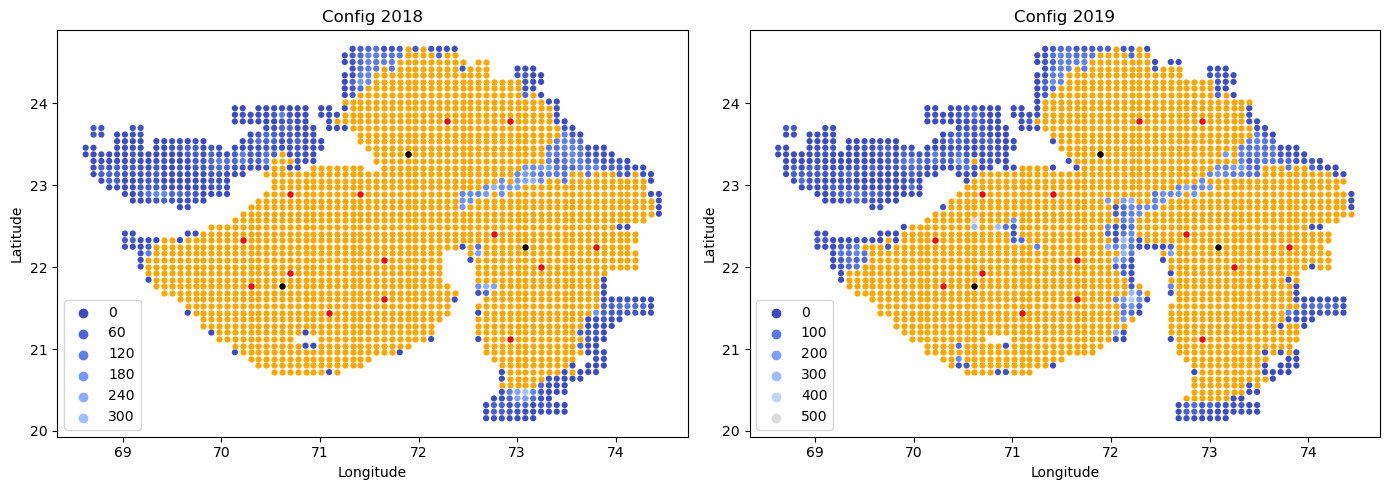

In [191]:
# Plot the whole configuration network
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
sns.scatterplot(data=dfcluster[~dfcluster['Index'].isin(used_2018)],x='Longitude',y='Latitude',hue='2018', palette='coolwarm', hue_norm=(0,1000), s=20, linewidth=0, ax=axes[0])
sns.scatterplot(data=dfcluster[~dfcluster['Index'].isin(used_2019)],x='Longitude',y='Latitude',hue='2019', palette='coolwarm', hue_norm=(0,1000), s=20, linewidth=0, ax=axes[1])
sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(used_2018)], x='Longitude', y='Latitude', color='orange', s=20, linewidth=0, ax=axes[0])
sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(used_2019)], x='Longitude', y='Latitude', color='orange', s=20, linewidth=0, ax=axes[1])
sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(list(group_dict_2018.keys()))], x='Longitude', y='Latitude', color='red', s=20, linewidth=0, ax=axes[0])
sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(list(group_dict_2019.keys()))], x='Longitude', y='Latitude', color='red', s=20, linewidth=0, ax=axes[1])
sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(use)], x='Longitude', y='Latitude', color='black', s=20, linewidth=0, ax=axes[0])
sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(use)], x='Longitude', y='Latitude', color='black', s=20, linewidth=0, ax=axes[1])
axes[0].set_title('Config 2018')
axes[1].set_title('Config 2019')
plt.tight_layout()
plt.show()

In [192]:
# Create submission dataframe
submission = pd.DataFrame(columns=['year', 'data_type', 'source_index', 'destination_index', 'value'])
submission

Empty DataFrame
Columns: [year, data_type, source_index, destination_index, value]
Index: []

In [193]:
depot_rows = {
    'year': '20182019',
    'data_type': 'depot_location',
    'source_index': list(group_dict_2018.keys()),
    'destination_index': None,  # Empty destination_index
    'value': None  # Empty value
}
refinery_rows = {
    'year': '20182019',
    'data_type': 'refinery_location',
    'source_index': use,
    'destination_index': None,  # Empty destination_index
    'value': None  # Empty value
}

submission = pd.concat([submission,pd.DataFrame(depot_rows),pd.DataFrame(refinery_rows)],ignore_index=True)

forecast_2018 = {
    'year': '2018',
    'data_type' : 'biomass_forecast',
    'source_index' : dfcluster['Index'],
    'destination_index': None,
    'value': df_2018['2018']
}
forecast_2019 = {
    'year': '2019',
    'data_type' : 'biomass_forecast',
    'source_index' : dfcluster['Index'],
    'destination_index': None,
    'value': df_2019['2019']
}

submission = pd.concat([submission,pd.DataFrame(forecast_2018),pd.DataFrame(forecast_2019)],ignore_index=True)

biomass_demand_18 = pd.DataFrame(group_dict_2018.items(),columns=['depot_loc','site_loc']).explode('site_loc')
biomass_demand_19 = pd.DataFrame(group_dict_2019.items(),columns=['depot_loc','site_loc']).explode('site_loc')

biomass_demand_2018 = {
    'year': '2018',
    'data_type' : 'biomass_demand_supply',
    'source_index' : biomass_demand_18['site_loc'],
    'destination_index': biomass_demand_18['depot_loc']
}
biomass_demand_2019 = {
    'year': '2019',
    'data_type' : 'biomass_demand_supply',
    'source_index' : biomass_demand_19['site_loc'],
    'destination_index': biomass_demand_19['depot_loc']
}

biomass_demand_2018 = pd.DataFrame(biomass_demand_2018).merge(df_2018[['Index','2018']], left_on='source_index', right_on='Index', how='left')
biomass_demand_2019 = pd.DataFrame(biomass_demand_2019).merge(df_2019[['Index','2019']], left_on='source_index', right_on='Index', how='left')

biomass_demand_2018 = biomass_demand_2018.drop(columns=['Index']).rename(columns={'2018':'value'})
biomass_demand_2019 = biomass_demand_2019.drop(columns=['Index']).rename(columns={'2019':'value'})

submission = pd.concat([submission,biomass_demand_2018,biomass_demand_2019],ignore_index=True)

dftemp = pd.DataFrame(list(assign.items()), columns=['source_index', 'destination_index']).explode('destination_index')

pellet_demand = pd.DataFrame()
pellet_demand['source_index'], pellet_demand['destination_index'] = dftemp['destination_index'], dftemp['source_index']

pellet_demand_2018 = {
    'year': '2018',
    'data_type' : 'pellet_demand_supply',
    'source_index' : pellet_demand['source_index'].astype(int),
    'destination_index': pellet_demand['destination_index'].astype(int)
}
pellet_demand_2019 = {
    'year': '2019',
    'data_type' : 'pellet_demand_supply',
    'source_index' : pellet_demand['source_index'].astype(int),
    'destination_index': pellet_demand['destination_index'].astype(int)
}

pellet_demand_2018 = pd.DataFrame(pellet_demand_2018).merge(dfdepot[['depot_index','2018']], how='left', left_on='source_index', right_on='depot_index')
pellet_demand_2019 = pd.DataFrame(pellet_demand_2019).merge(dfdepot[['depot_index','2019']], how='left', left_on='source_index', right_on='depot_index')

pellet_demand_2018 = pellet_demand_2018.drop(columns=['depot_index']).rename(columns={'2018':'value'})
pellet_demand_2019 = pellet_demand_2019.drop(columns=['depot_index']).rename(columns={'2019':'value'})

submission = pd.concat([submission,pellet_demand_2018,pellet_demand_2019],ignore_index=True)

In [ ]:
submission.to_csv('test_submit.csv')

In [194]:
# Check constraint number 8
x = submission[submission['data_type']=='pellet_demand_supply'].groupby(by=['year','source_index'])['value'].sum().reset_index()
y = submission[submission['data_type']=='biomass_demand_supply'].groupby(by=['year','destination_index'])['value'].sum().reset_index()

merged = pd.merge(y, x, left_on=['year', 'destination_index'], right_on=['year', 'source_index'], suffixes=('_destination', '_source'))
merged['diff'] = abs(merged['value_destination']-merged['value_source'])

merged

year  destination_index value_destination  source_index value_source diff
0   2018                301             20000           301        20000    0
1   2018                309             20000           309        20000    0
2   2018                547             20000           547        20000    0
3   2018                921             20000           921        20000    0
4   2018                930             20000           930        20000    0
5   2018               1288             20000          1288        20000    0
6   2018               1322             20000          1322        20000    0
7   2018               1433             20000          1433        20000    0
8   2018               1530             20000          1530        20000    0
9   2018               1607             20000          1607        20000    0
10  2018               1638             20000          1638        20000    0
11  2018               1742             20000          1742        20000    0
12  2018               1866             20000          1866        20000    0
13  2018               1973             20000          1973        20000    0
14  2018               2185             20000          2185        20000    0
15  2019                301             20000           301        20000    0
16  2019                309             20000           309        20000    0
17  2019                547             20000           547        20000    0
18  2019                921             20000           921        20000    0
19  2019                930             20000           930        20000    0
20  2019               1288             20000          1288        20000    0
21  2019               1322             20000          1322        20000    0
22  2019               1433             20000          1433        20000    0
23  2019               1530             20000          1530        20000    0
24  2019               1607             20000          1607        20000    0
25  2019               1638             20000          1638        20000    0
26  2019               1742             20000          1742        20000    0
27  2019               1866             20000          1866        20000    0
28  2019               1973             20000          1973        20000    0
29  2019               2185             20000          2185        20000    0